In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

import pandas as pd

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.keras as iso

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 20000
n_train_neg = 20000

n_test_pos = 2000
n_test_neg = 2000

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [6]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [7]:
#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]
[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = data_gens['test'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))
print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l2_test.shape = " + str(l_2_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
x_1_test.shape = (4000, 1, 81, 20)
x_2_test.shape = (4000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
l_1_test.shape = (4000, 1)
l2_test.shape = (4000, 1)
y_train.shape = (40000, 1)
y_test.shape = (4000, 1)


In [8]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [9]:
#Load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [10]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [11]:
#Load predictor model

def get_shared_model() :
    
    gru_1 = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')
    
    drop_1 = Dropout(0.25)

    def shared_model(inp) :

        gru_1_out = gru_1(inp)
        
        drop_1_out = drop_1(gru_1_out)

        return drop_1_out
    
    return shared_model

shared_model = get_shared_model()

#Inputs
res_1 = Input(shape=(seq_length, 19 + 1))
res_2 = Input(shape=(seq_length, 19 + 1))

#Outputs
true_interacts = Input(shape=(1,))

#Interaction model definition
dense_out_1 = shared_model(res_1)
dense_out_2 = shared_model(res_2)

layer_dense_pair_1 = Dense(128, activation='relu')
dense_out_pair = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))

pred_interacts = Dense(1, activation='sigmoid', kernel_initializer='zeros')(dense_out_pair)

predictor = Model(
    inputs=[
        res_1,
        res_2
    ],
    outputs=pred_interacts
)

predictor.load_weights('saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5', by_name=True)
predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
#Generate (original) predictions

pred_train = predictor.predict([x_1_train[:, 0, ...], x_2_train[:, 0, ...]], batch_size=32)
pred_test = predictor.predict([x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32)

pred_train = np.concatenate([1. - pred_train, pred_train], axis=1)
pred_test = np.concatenate([1. - pred_test, pred_test], axis=1)


In [13]:
#Make two-channel targets

y_train = np.concatenate([1. - y_train, y_train], axis=1)
y_test = np.concatenate([1. - y_test, y_test], axis=1)


In [14]:
from keras.layers import Input, Dense, Multiply, Flatten, Reshape, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

import tensorflow as tf
import numpy as np

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    def __init__(self, axes=(1, 2), trainable=True, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.axes = axes
        self.trainable = trainable
    def build(self, input_shape):
        self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                     initializer='zeros',trainable=self.trainable)
        self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                     initializer='ones',trainable=self.trainable)
    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, self.axes, keep_dims=True)
        return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

def bernoulli_sampling (prob):
    """ Sampling Bernoulli distribution by given probability.

    Args:
    - prob: P(Y = 1) in Bernoulli distribution.

    Returns:
    - samples: samples from Bernoulli distribution
    """  

    n, x_len, y_len, d = prob.shape
    samples = np.random.binomial(1, prob, (n, x_len, y_len, d))

    return samples

class INVASE():
    """INVASE class.

    Attributes:
    - x_train: training features
    - y_train: training labels
    - model_type: invase or invase_minus
    - model_parameters:
      - actor_h_dim: hidden state dimensions for actor
      - critic_h_dim: hidden state dimensions for critic
      - n_layer: the number of layers
      - batch_size: the number of samples in mini batch
      - iteration: the number of iterations
      - activation: activation function of models
      - learning_rate: learning rate of model training
      - lamda: hyper-parameter of INVASE
    """

    def __init__(self, x_train, y_train, model_type, model_parameters):

        self.lamda = model_parameters['lamda']
        self.actor_h_dim = model_parameters['actor_h_dim']
        self.critic_h_dim = model_parameters['critic_h_dim']
        self.n_layer = model_parameters['n_layer']
        self.batch_size = model_parameters['batch_size']
        self.iteration = model_parameters['iteration']
        self.activation = model_parameters['activation']
        self.learning_rate = model_parameters['learning_rate']

        #Modified Code
        self.x_len = x_train.shape[1]
        self.y_len = x_train.shape[2]
        self.dim = x_train.shape[3] 
        self.label_dim = y_train.shape[1]

        self.model_type = model_type

        optimizer = Adam(self.learning_rate)

        # Build and compile critic
        self.critic = self.build_critic()
        self.critic.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, metrics=['acc'])

        # Build and compile the actor
        self.actor = self.build_actor()
        self.actor.compile(loss=self.actor_loss, optimizer=optimizer)

        if self.model_type == 'invase':
            # Build and compile the baseline
            self.baseline = self.build_baseline()
            self.baseline.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


    def actor_loss(self, y_true, y_pred):
        """Custom loss for the actor.

        Args:
          - y_true:
            - actor_out: actor output after sampling
            - critic_out: critic output 
            - baseline_out: baseline output (only for invase)
          - y_pred: output of the actor network

        Returns:
          - loss: actor loss
        """
        
        y_pred = K.reshape(y_pred, (K.shape(y_pred)[0], self.x_len*self.y_len*1))
        y_true = y_true[:, 0, 0, :]

        # Actor output
        actor_out = y_true[:, :self.x_len*self.y_len*1]
        # Critic output
        critic_out = y_true[:, self.x_len*self.y_len*1:(self.x_len*self.y_len*1+self.label_dim)]

        if self.model_type == 'invase':
            # Baseline output
            baseline_out = \
            y_true[:, (self.x_len*self.y_len*1+self.label_dim):(self.x_len*self.y_len*1+2*self.label_dim)]
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+2*self.label_dim):]        
        elif self.model_type == 'invase_minus':
            # Ground truth label
            y_out = y_true[:, (self.x_len*self.y_len*1+self.label_dim):]         

        # Critic loss
        critic_loss = -tf.reduce_sum(y_out * tf.log(critic_out + 1e-8), axis = 1)  

        if self.model_type == 'invase':        
            # Baseline loss
            baseline_loss = -tf.reduce_sum(y_out * tf.log(baseline_out + 1e-8), 
                                         axis = 1)  
            # Reward
            Reward = -(critic_loss - baseline_loss)
        elif self.model_type == 'invase_minus':
            Reward = -critic_loss

        # Policy gradient loss computation. 
        custom_actor_loss = \
        Reward * tf.reduce_sum(actor_out * K.log(y_pred + 1e-8) + \
        (1-actor_out) * K.log(1-y_pred + 1e-8), axis = 1) - \
        self.lamda * tf.reduce_mean(y_pred, axis = 1)

        # custom actor loss
        custom_actor_loss = tf.reduce_mean(-custom_actor_loss)

        return custom_actor_loss


    def build_actor(self):
        """Build actor.

        Use feature as the input and output selection probability
        """
        actor_model = Sequential()
        
        actor_model.add(Conv2D(self.actor_h_dim, (1, 3), padding='same', activation='linear'))
        actor_model.add(InstanceNormalization())
        actor_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            actor_model.add(Conv2D(self.actor_h_dim, (1, 3), padding='same', activation='linear'))
            actor_model.add(InstanceNormalization())
            actor_model.add(Activation(self.activation))
        actor_model.add(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))

        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        selection_probability = actor_model(feature)

        return Model(feature, selection_probability)


    def build_critic(self):
        """Build critic.

        Use selected feature as the input and predict labels
        """
        critic_model = Sequential()
        
        critic_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
        critic_model.add(InstanceNormalization())
        critic_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            critic_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
            critic_model.add(InstanceNormalization())
            critic_model.add(Activation(self.activation))
        critic_model.add(Flatten())
        critic_model.add(Dense(self.critic_h_dim, activation=self.activation))
        #critic_model.add(Dropout(0.2))
        critic_model.add(Dense(self.label_dim, activation ='softmax'))

        ## Inputs
        # Features
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')
        # Binary selection
        selection = Input(shape=(self.x_len, self.y_len, 1), dtype='float32')         

        # Element-wise multiplication
        critic_model_input = Multiply()([feature, selection])
        y_hat = critic_model(critic_model_input)

        return Model([feature, selection], y_hat)


    def build_baseline(self):
        """Build baseline.

        Use the feature as the input and predict labels
        """
        baseline_model = Sequential()
        
        baseline_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
        baseline_model.add(InstanceNormalization())
        baseline_model.add(Activation(self.activation))
        for _ in range(self.n_layer - 2):
            baseline_model.add(Conv2D(self.critic_h_dim, (1, 3), padding='same', activation='linear'))
            baseline_model.add(InstanceNormalization())
            baseline_model.add(Activation(self.activation))
        baseline_model.add(Flatten())
        baseline_model.add(Dense(self.critic_h_dim, activation=self.activation))
        #baseline_model.add(Dropout(0.2))
        baseline_model.add(Dense(self.label_dim, activation ='softmax'))

        # Input
        feature = Input(shape=(self.x_len, self.y_len, self.dim), dtype='float32')       
        # Output        
        y_hat = baseline_model(feature)

        return Model(feature, y_hat)


    def train(self, x_train, y_train):
        """Train INVASE.

        Args:
          - x_train: training features
          - y_train: training labels
        """

        for iter_idx in range(self.iteration):

            ## Train critic
            # Select a random batch of samples
            idx = np.random.randint(0, x_train.shape[0], self.batch_size)
            x_batch = x_train[idx,:]
            y_batch = y_train[idx,:]

            # Generate a batch of selection probability
            selection_probability = self.actor.predict(x_batch)            
            # Sampling the features based on the selection_probability
            selection = bernoulli_sampling(selection_probability)     
            # Critic loss
            critic_loss = self.critic.train_on_batch([x_batch, selection], y_batch)                        
            # Critic output
            critic_out = self.critic.predict([x_batch, selection])

            # Baseline output
            if self.model_type == 'invase':   
              # Baseline loss
              baseline_loss = self.baseline.train_on_batch(x_batch, y_batch)                        
              # Baseline output
              baseline_out = self.baseline.predict(x_batch)

            ## Train actor
            # Use multiple things as the y_true: 
            # - selection, critic_out, baseline_out, and ground truth (y_batch)
            if self.model_type == 'invase':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            np.asarray(baseline_out), 
                                            y_batch), axis = 1)
            elif self.model_type == 'invase_minus':
                y_batch_final = np.concatenate((np.reshape(selection, (y_batch.shape[0], -1)), 
                                            np.asarray(critic_out), 
                                            y_batch), axis = 1)

            y_batch_final = y_batch_final[:, None, None, :]
            
            # Train the actor
            actor_loss = self.actor.train_on_batch(x_batch, y_batch_final)

            if self.model_type == 'invase':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', baseline accuracy: ' + str(baseline_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))
            elif self.model_type == 'invase_minus':
                # Print the progress
                dialog = 'Iterations: ' + str(iter_idx) + \
                     ', critic accuracy: ' + str(critic_loss[1]) + \
                     ', actor loss: ' + str(np.round(actor_loss,4))

            if iter_idx % 100 == 0:
                print(dialog)

    def importance_score(self, x):
        """Return featuer importance score.

        Args:
          - x: feature

        Returns:
          - feature_importance: instance-wise feature importance for x
        """        
        feature_importance = self.actor.predict(x)        
        return np.asarray(feature_importance)


    def predict(self, x):
        """Predict outcomes.

        Args:
          - x: feature

        Returns:
          - y_hat: predictions    
        """        
        # Generate a batch of selection probability
        selection_probability = self.actor.predict(x)            
        # Sampling the features based on the selection_probability
        selection = bernoulli_sampling(selection_probability)   
        # Prediction 
        y_hat = self.critic.predict([x, selection])

        return np.asarray(y_hat)


In [15]:
#Concatenate input binder pairs

x_train = np.concatenate([x_1_train, x_2_train], axis=2)
x_test = np.concatenate([x_1_test, x_2_test], axis=2)


In [16]:
#Execute INVASE

mask_penalty = 0.05
hidden_dims = 32
n_layers = 4
epochs = 50
batch_size = 128

model_parameters = {
    'lamda': mask_penalty,
    'actor_h_dim': hidden_dims, 
    'critic_h_dim': hidden_dims,
    'n_layer': n_layers,
    'batch_size': batch_size,
    'iteration': int(x_train.shape[0] * epochs / batch_size), 
    'activation': 'relu', 
    'learning_rate': 0.0001
}

invase_model = INVASE(x_train, pred_train, 'invase', model_parameters)

invase_model.train(x_train, pred_train)    

importance_scores_test = invase_model.importance_score(x_test)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Instructions for updating:
Use tf.cast instead.
Iterations: 0, critic accuracy: 0.5078125, baseline accuracy: 0.4296875, actor loss: 5.9101
Iterations: 100, critic accuracy: 0.5703125, baseline accuracy: 0.578125, actor loss: -0.804
Iterations: 200, critic accuracy: 0.625, baseline accuracy: 0.6171875, actor loss: -0.5963
Iterations: 300, critic accuracy: 0.5859375, baseline accuracy: 0.5859375, actor loss: -0.1151
Iterations: 400, critic accuracy: 0.65625, baseline accuracy: 0.6640625, actor loss: -1.2832
Iterations: 500, critic accuracy: 0.59375, baseline accuracy: 0.609375, actor loss: -3.1862
Iterations: 600, critic accuracy: 0.578125, baseline accuracy: 0.5625, actor loss: -0.715
Iterations: 700, critic accuracy: 0.578125, baseline accuracy: 0.59375, actor loss: -1.5957
Iterations: 800, critic accuracy: 0.5625, baseline accuracy: 0.5859375, actor loss: -4.0112
Iterations: 900, critic accuracy: 0.5390625, baseline accuracy: 0.546875, actor loss: -3.9869
Iterations: 1000, critic acc

Iterations: 8400, critic accuracy: 0.6484375, baseline accuracy: 0.9375, actor loss: -24.3751
Iterations: 8500, critic accuracy: 0.703125, baseline accuracy: 0.953125, actor loss: -26.3412
Iterations: 8600, critic accuracy: 0.6484375, baseline accuracy: 0.96875, actor loss: -24.8289
Iterations: 8700, critic accuracy: 0.75, baseline accuracy: 0.9765625, actor loss: -25.3733
Iterations: 8800, critic accuracy: 0.703125, baseline accuracy: 0.96875, actor loss: -26.2619
Iterations: 8900, critic accuracy: 0.6875, baseline accuracy: 0.9765625, actor loss: -22.8815
Iterations: 9000, critic accuracy: 0.703125, baseline accuracy: 0.9765625, actor loss: -24.448
Iterations: 9100, critic accuracy: 0.6484375, baseline accuracy: 0.9765625, actor loss: -27.0881
Iterations: 9200, critic accuracy: 0.59375, baseline accuracy: 0.96875, actor loss: -27.0423
Iterations: 9300, critic accuracy: 0.6875, baseline accuracy: 0.9609375, actor loss: -23.7842
Iterations: 9400, critic accuracy: 0.6640625, baseline ac

In [17]:
#Evaluate INVASE model on train and test data

invase_pred_train = invase_model.predict(x_train)
invase_pred_test = invase_model.predict(x_test)

print("Training Accuracy = " + str(np.sum(np.argmax(invase_pred_train, axis=1) == np.argmax(pred_train, axis=1)) / float(pred_train.shape[0])))
print("Test Accuracy     = " + str(np.sum(np.argmax(invase_pred_test, axis=1) == np.argmax(pred_test, axis=1)) / float(pred_test.shape[0])))


Training Accuracy = 0.74015
Test Accuracy     = 0.45625


In [16]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_protein_logo(residue_map, pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164) :

    inv_residue_map = {
        i : sp for sp, i in residue_map.items()
    }

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(np.clip(pwm[pwm > 0], 1e-6, 1. - 1e-6))
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(residue_map)) :
            i = sort_index[ii]
            
            if pwm[j, i] > 0 :
                nt_prob = pwm[j, i] * conservation[j]

                nt = inv_residue_map[i]

                color = None
                if sequence_template[j] != '$' :
                    color = 'black'

                if ii == 0 :
                    letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        letterAt_protein(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=None)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [19]:

np.sum(importance_scores_1_test[0, 0, :, 0] + importance_scores_2_test[0, 0, :, 0])


69.686584

In [20]:

np.max(importance_scores_1_test[0, 0, :, 0])


0.99908763

Test sequence 0:


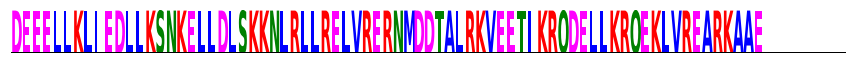

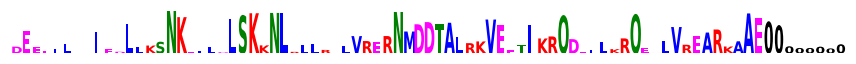

Test sequence 1:


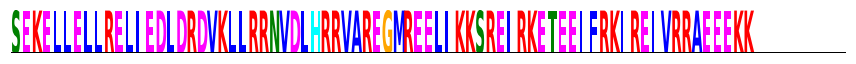

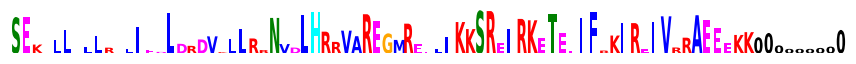

Test sequence 2:


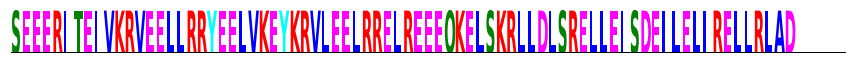

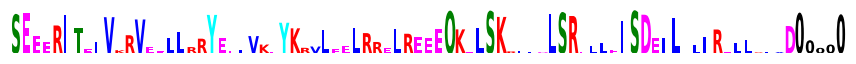

Test sequence 3:


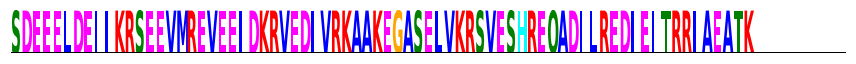

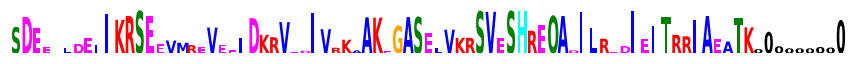

Test sequence 4:


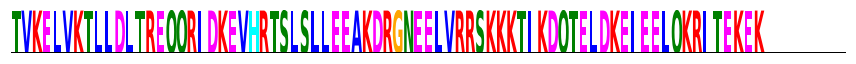

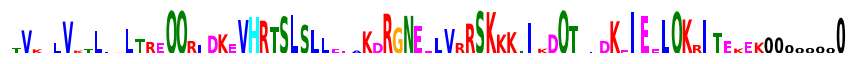

Test sequence 0:


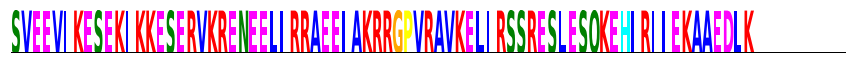

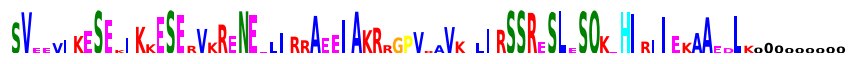

Test sequence 1:


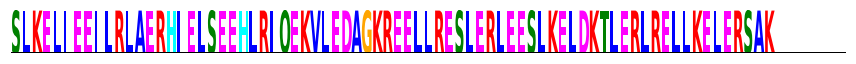

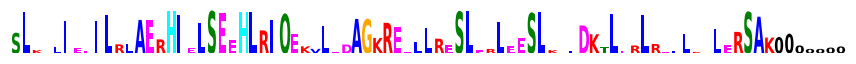

Test sequence 2:


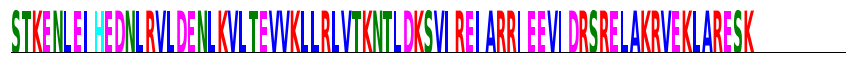

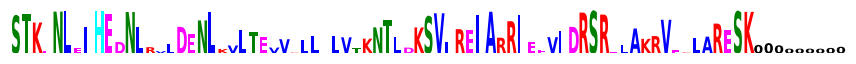

Test sequence 3:


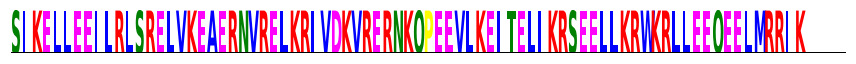

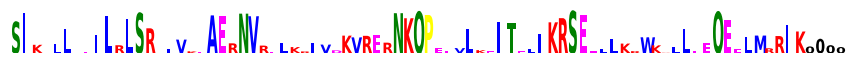

Test sequence 4:


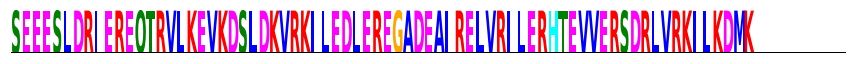

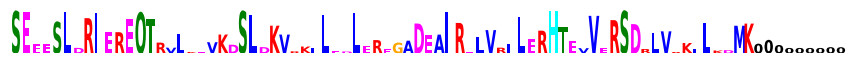

In [21]:
#Visualize importance for binder 1

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)

#Visualize importance for binder 2

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)


In [22]:
#Save predicted importance scores

model_name = "invase_" + dataset_name + "_conv" + "_zeropad_no_drop_penalty_005"

np.save(model_name + "_importance_scores_1_test", importance_scores_1_test)
np.save(model_name + "_importance_scores_2_test", importance_scores_2_test)


In [17]:
#Binder DHD_154

seq_1 = "TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN"[:81]
seq_2 = "DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE"[:81]

print("Seq 1 = " + seq_1)
print("Seq 2 = " + seq_2)

encoder = IdentityEncoder(81, residue_map)

test_onehot_1 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_1), axis=0), axis=0), (batch_size, 1, 1, 1))
test_onehot_2 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_2), axis=0), axis=0), (batch_size, 1, 1, 1))

test_len_1 = np.tile(np.array([[len(seq_1)]]), (batch_size, 1))
test_len_2 = np.tile(np.array([[len(seq_2)]]), (batch_size, 1))

pred_interacts = predictor.predict(x=[test_onehot_1[:, 0, ...], test_onehot_2[:, 0, ...]])[0, 0]

print("Predicted interaction prob = " + str(round(pred_interacts, 4)))


Seq 1 = TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN
Seq 2 = DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE
Predicted interaction prob = 0.8533


In [20]:

x_1_test = test_onehot_1[:1]
x_2_test = test_onehot_2[:1]

#Concatenate input binder pairs

x_test = np.concatenate([x_1_test, x_2_test], axis=2)

#Execute INVASE

mask_penalty = 0.05
hidden_dims = 32
n_layers = 4
epochs = 50
batch_size = 128

model_parameters = {
    'lamda': mask_penalty,
    'actor_h_dim': hidden_dims, 
    'critic_h_dim': hidden_dims,
    'n_layer': n_layers,
    'batch_size': batch_size,
    'iteration': int(x_train.shape[0] * epochs / batch_size), 
    'activation': 'relu', 
    'learning_rate': 0.0001
}

invase_model = INVASE(x_train, pred_train, 'invase', model_parameters)

invase_model.train(x_train, pred_train)    

importance_scores_test = invase_model.importance_score(x_test)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Iterations: 0, critic accuracy: 0.5234375, baseline accuracy: 0.59375, actor loss: -5.0293
Iterations: 100, critic accuracy: 0.59375, baseline accuracy: 0.59375, actor loss: -0.4701
Iterations: 200, critic accuracy: 0.5625, baseline accuracy: 0.5625, actor loss: 1.1175
Iterations: 300, critic accuracy: 0.609375, baseline accuracy: 0.609375, actor loss: 0.8147
Iterations: 400, critic accuracy: 0.53125, baseline accuracy: 0.53125, actor loss: -0.9603
Iterations: 500, critic accuracy: 0.5234375, baseline accuracy: 0.5234375, actor loss: -1.5065
Iterations: 600, critic accuracy: 0.6171875, baseline accuracy: 0.640625, actor loss: -1.7839
Iterations: 700, critic accuracy: 0.5703125, baseline accuracy: 0.5703125, actor loss: -2.4161
Iterations: 800, critic accuracy: 0.5625, baseline accuracy: 0.6328125, actor loss: -2.8021
Iterations: 900, critic accuracy: 0.609375, baseline accuracy: 0.640625, actor loss: -2.1502
Iterations: 1000, critic accuracy: 0.5703125, baseline accuracy: 0.59375, acto

Iterations: 8700, critic accuracy: 0.625, baseline accuracy: 0.9765625, actor loss: -27.1395
Iterations: 8800, critic accuracy: 0.6484375, baseline accuracy: 0.96875, actor loss: -26.4965
Iterations: 8900, critic accuracy: 0.6953125, baseline accuracy: 0.984375, actor loss: -27.3502
Iterations: 9000, critic accuracy: 0.6015625, baseline accuracy: 0.9375, actor loss: -27.9804
Iterations: 9100, critic accuracy: 0.5546875, baseline accuracy: 0.96875, actor loss: -27.4351
Iterations: 9200, critic accuracy: 0.6484375, baseline accuracy: 0.9765625, actor loss: -26.8968
Iterations: 9300, critic accuracy: 0.6875, baseline accuracy: 0.9609375, actor loss: -26.022
Iterations: 9400, critic accuracy: 0.6171875, baseline accuracy: 0.9609375, actor loss: -27.373
Iterations: 9500, critic accuracy: 0.65625, baseline accuracy: 0.96875, actor loss: -28.1647
Iterations: 9600, critic accuracy: 0.6015625, baseline accuracy: 0.984375, actor loss: -27.4902
Iterations: 9700, critic accuracy: 0.6328125, baseli

Test sequence 0:


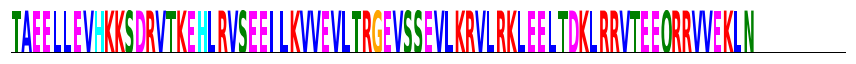

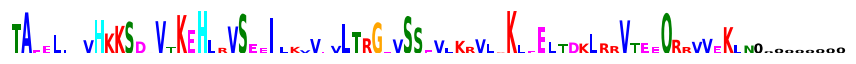

Test sequence 0:


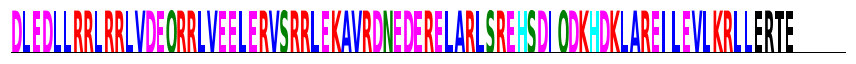

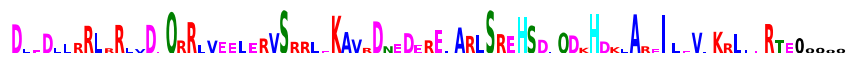

In [23]:

save_figs = True

model_name = "invase_" + dataset_name + "_conv" + "_zeropad_no_drop_penalty_005"

pair_name = "DHD_154"

#Visualize importance for binder 1

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_1")

#Visualize importance for binder 2

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_2")
